<p>Импортируем необходимые зависимости

In [1]:
from numpy import genfromtxt
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\galic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функция предварительной обработки комментариев

In [2]:
def prepare_rewiew(text):
    try:
        final = re.sub('[!|#|$|\%|&|@|[|\]|\_|.|,|\n|?]+', ' ', text).lower().strip()
        final = final if final else None
        return final 
    except AttributeError:
        return text.lower().strip() if text.lower().strip() else None
def prepare_problem(text):
    dictionary = [
        'Городская среда', 'Доставка', 'Товар', 'Поддержка','Постамат', 'Упаковка','Другое'
    ]
    return dictionary.index(text) if text else None

Загрузка датасета для обучения

In [3]:
converters = {'data': prepare_rewiew,
              'problem': prepare_problem
             }
dataset = pd.read_csv('./datasets/train_problem.csv', sep=';', header=0, converters = converters) \
    .rename(columns={"data": "comment", 'problem': 'problem'})
dataset = dataset.dropna().drop_duplicates()
dataset.head(5)

,comment,problem
0,вы что специально прячите почтоматы и даёте сс...,0.0
1,постомат не доступен магазин был закрыт,0.0
2,в описании пункта выдачи неплохо бы пояснить ...,0.0
3,магазин в котором находится постамат открылся...,0.0
4,пункт выдачи даже близко не там где написано ...,0.0


Определение распределения категорий проблем

<Axes: xlabel='problem', ylabel='count'>

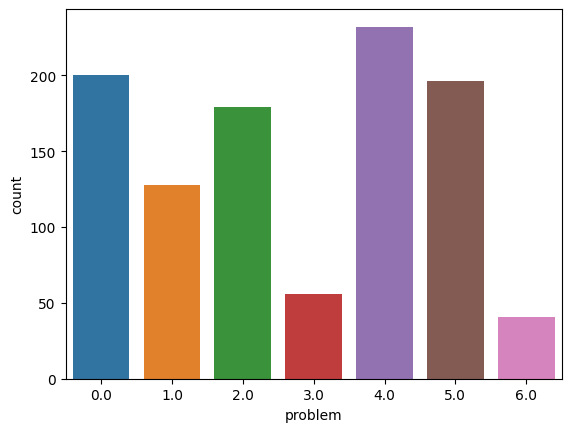

In [4]:
import seaborn as sns
sns.countplot(data=dataset, x="problem")

Формаирование списка стоп-слов

In [5]:
additional_stopwords = ['которых','которые','твой','которой','которого','сих','ком','свой','твоя','этими','слишком','нами','всему', 'будь','саму','чаще','ваше','сами','наш','затем', 'самих','наши','ту','каждое','мочь','весь','этим', 'наша','своих','оба','который','зато','те','этих','вся', 'ваш','такая','теми','ею','которая','нередко','каждая', 'также','чему','собой','самими','нем','вами','ими', 'откуда','такие','тому','та','очень','сама','нему',
'алло','оно','этому','кому','тобой','таки','твоё', 'каждые','твои','нею','самим','ваши','ваша','кем','мои','однако','сразу','свое','ними','всё','неё','тех','хотя','всем','тобою','тебе','одной','другие','само','эта', 'самой','моё','своей','такое','всею','будут','своего', 'кого','свои','мог','нам','особенно','её','самому',
'наше','кроме','вообще','вон','мною','никто','это']

stop_words = stopwords.words('russian') + additional_stopwords

Формирование обучающей выборки и тестового подмножества

In [6]:
x_train, x_test, y_train, y_test = train_test_split(dataset['comment'], dataset['problem'], test_size=0.25, random_state=0)


Обучение модели векторизации текста по методу Tfidf

In [7]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words=stop_words,
                             use_idf=True, ngram_range=(1,1),
                             smooth_idf=False)
vectorizer.fit(dataset['comment'])

TfidfVectorizer(smooth_idf=False,
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

Веторизация подмножеств для обучения

In [8]:
X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)

Обучение моделей Логистической регрессии и выбор лучшей

In [9]:
from sklearn.linear_model import LogisticRegression

param_grid = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C': np.logspace(-4, 4, 20)},
             {'max_iter' : [100, 1000,2500, 5000]}
             ]

logreg = LogisticRegression()
clf = GridSearchCV(logreg, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
result_logreg = clf.fit(X_train, y_train)
result_logreg.score(X_test,y_test)

Fitting 3 folds for each of 33 candidates, totalling 99 fits


C:\Users\galic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 99.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\galic\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\galic\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\galic\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueEr

0.8178294573643411

Определение показателя Accuracy

In [10]:
print (f'Accuracy - : {result_logreg.score(X_test,y_test):.3f}')

Accuracy - : 0.818


Сохранение моделей

In [11]:
import pickle

with open("problem_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("model_problem.pkl", "wb") as f:
    pickle.dump(result_logreg, f)